In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}

import time
import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 14
import matplotlib.colors as cm
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

import superscreen as sc

## Superconducting ring

In [2]:
length_units = "um"

Lambda = 1
inner_diameter = 5
outer_diameter = 10

layers = [
    sc.Layer("base", Lambda=Lambda, z0=0),
]

films = [
    sc.Polygon(
        "ring",
        layer="base",
        points=sc.geometry.circle(outer_diameter / 2),
    ),
]

holes = [
    sc.Polygon(
        "hole",
        layer="base",
        points=sc.geometry.circle(inner_diameter / 2),
    ),
]

abstract_regions = [
    sc.Polygon(
        "bounding_box",
        layer="base",
        points=sc.geometry.circle(outer_diameter * 1.4 / 2, points=21),
    )
]

ring = sc.Device(
    "ring",
    layers=layers,
    films=films,
    holes=holes,
    abstract_regions=abstract_regions,
    length_units=length_units,
)

In [3]:
ring.make_mesh(min_triangles=8000, optimesh_steps=400)

INFO:superscreen.device:Generating mesh...
INFO:superscreen.device:Optimizing mesh with 8164 triangles.
INFO:superscreen.device:Finished generating mesh with 4167 points and 8164 triangles.
INFO:superscreen.device:Calculating weight matrix.
INFO:superscreen.device:Calculating Laplace operator.
INFO:superscreen.device:Calculating kernel matrix.


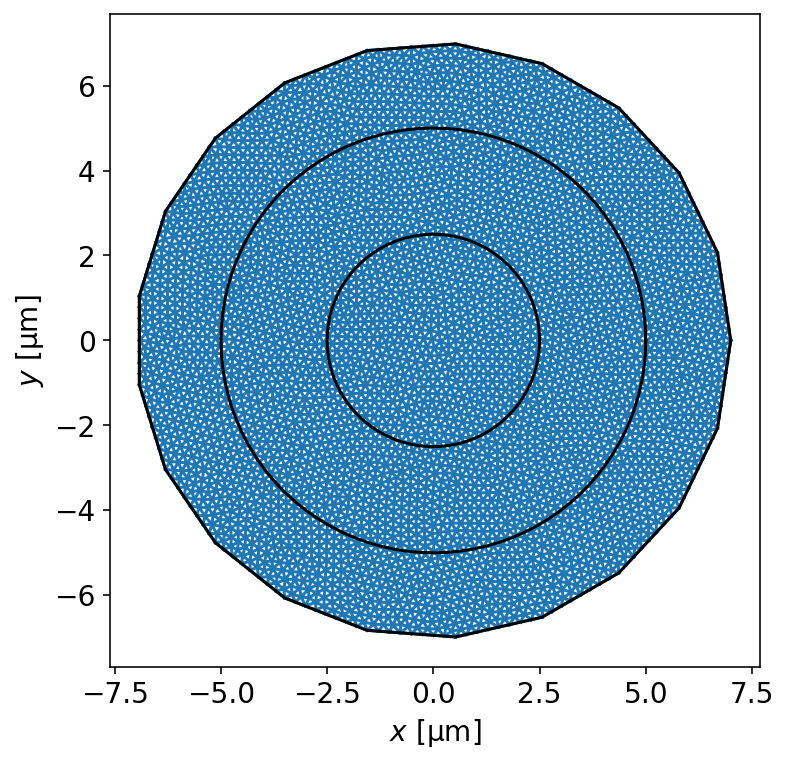

In [4]:
ax = ring.plot_mesh(figsize=(6, 6))
ax = ring.plot_polygons(ax=ax, color="k", legend=False)

In [5]:
circulating_currents = {"hole": "1 mA"}
field_solution = sc.solve(device=ring, circulating_currents=circulating_currents)[-1]

INFO:superscreen.brandt:Calculating base response to applied field.


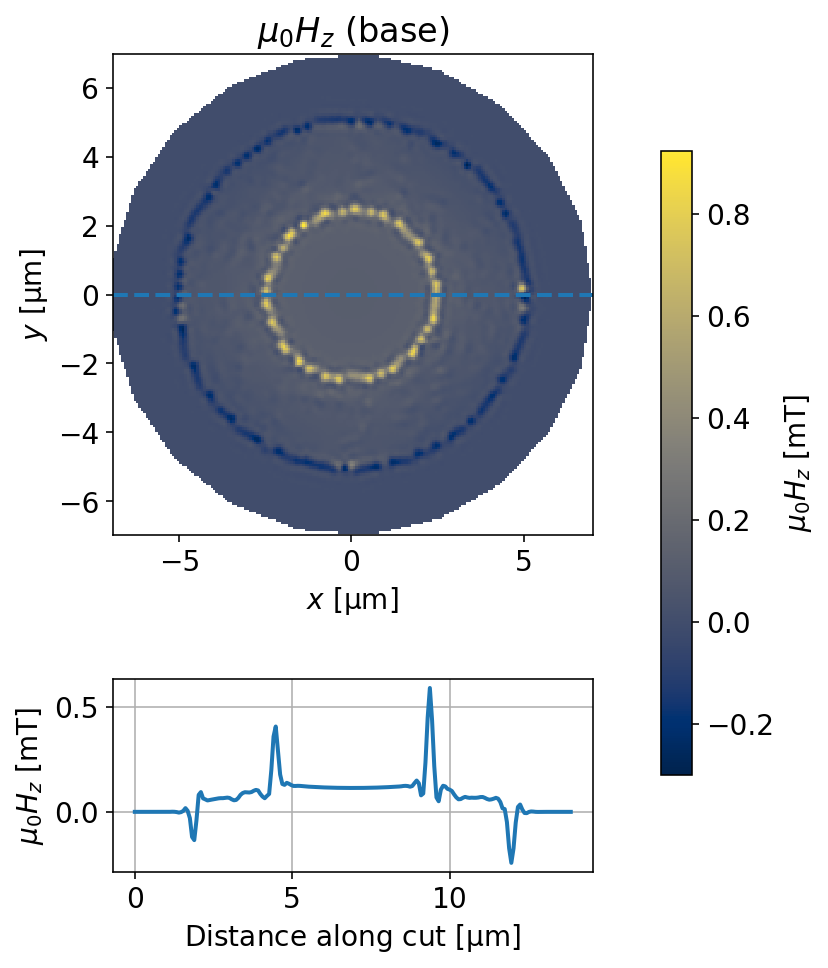

In [6]:
fig, axes = field_solution.plot_fields(figsize=(6, 7), cross_section_ys=[0])

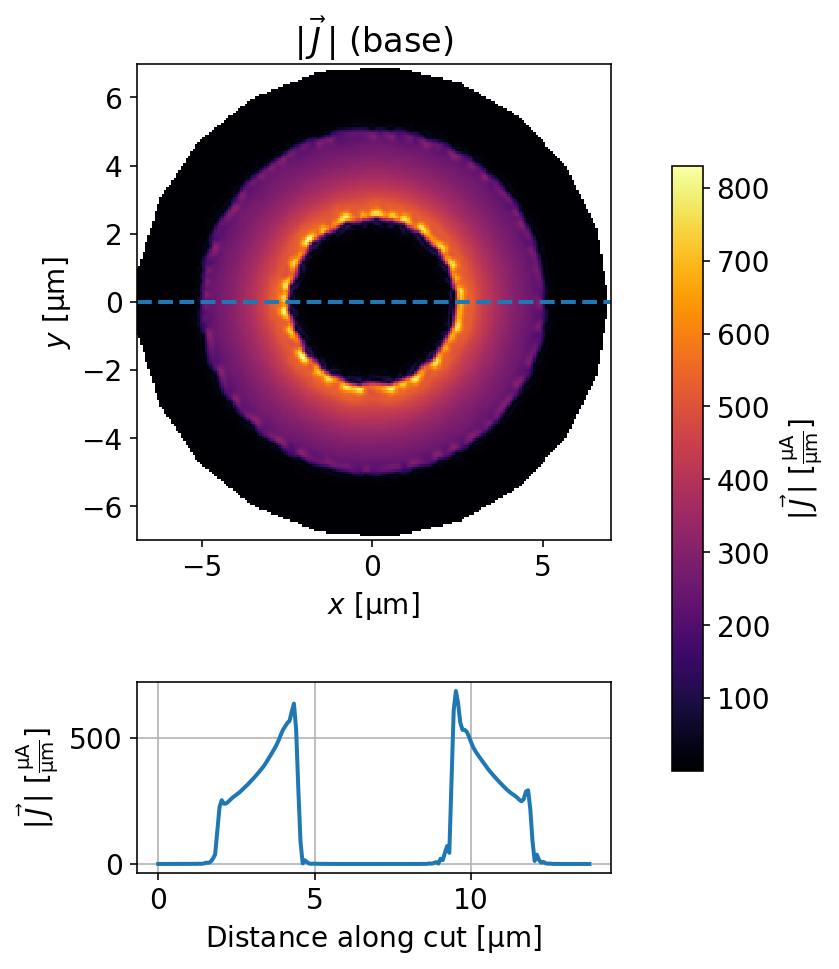

In [7]:
fig, axes = field_solution.plot_currents(figsize=(6, 7), cross_section_ys=[0], streamplot=False)

In [8]:
flux = field_solution.polygon_flux()

I_circ = ring.ureg(circulating_currents["hole"])

inductance = (flux["ring"] / I_circ).to("pH")
print(f"Inductance: {inductance:.3f~P}")

Inductance: 7.089 pH


In [113]:
def plot_solutions(solutions, Lambdas, figsize=(14, 10), grid_shape=200, cmap="viridis", lw=2.5):
    N = grid_shape // 2

    fig, axes = plt.subplots(2, 2, figsize=figsize)
    # (ax, bx), (cx, dx), (ex, fx) = axes
    (ax, bx), (cx, dx) = axes
    ax.set_aspect("equal")
    bx.set_aspect("equal")
    cx.grid(True)
    dx.grid(True)
    # ex.grid(True)
    # fx.grid(True)

    colors = plt.get_cmap(cmap)(np.linspace(0, 1, len(Lambdas)))

    for i, (solution, Lambda, color) in enumerate(zip(solutions, Lambdas, colors)):

        xgrid, ygrid, fields = solution.grid_data("fields", grid_shape=grid_shape)
        field = fields["base"]

        if Lambda == 1:
            im = ax.pcolormesh(xgrid, ygrid, field, shading="auto", cmap="cividis")
            ax.set_xlabel("$x$ [$\\mu$m]")
            ax.set_ylabel("$y$ [$\\mu$m]")
            ax.set_title("Magnetic field, $\\mu_0H_z$\n$\\Lambda$ = 1 $\\mu$m")
            ax_divider = make_axes_locatable(ax)
            cax = ax_divider.append_axes("right", size="8%", pad="4%")
            cbar = fig.colorbar(im, cax=cax)
            cbar.set_label(f"$\\mu_0H_z$ [{solution.field_units}]")
            ax.axhline(xvec[N], ls="--", color="w", lw=lw)
    
        xvec, yvec = sc.grids_to_vecs(xgrid, ygrid)
        cx.plot(xvec, field[N, :], color=color, lw=lw)
        # ex.plot(xvec, (field[N, :] - field[N, 0]) / np.nanmax(field[N, :]), color=color, lw=lw)

        xgrid, ygrid, jcs = solution.current_density(
            grid_shape=grid_shape, units="mA / um", with_units=True
        )
        jx, jy = jcs["base"].magnitude
        units = jcs["base"].units
        J = np.sqrt(jx**2 + jy**2)
        xvec, yvec = sc.grids_to_vecs(xgrid.magnitude, ygrid.magnitude)
        
        if i == 0:
            jxlabel = "$J_x$"
            jylabel = "$J_y$"
        else:
            jxlabel = jylabel = None

        dx.plot(xvec, jx[N, :], color=color, ls="--", lw=lw, label=jxlabel)
        dx.plot(xvec, jy[N, :], color=color, ls="-", lw=lw, label=jylabel)
        # fx.plot(xvec, jx[N, :] / np.nanmax(jx[N, :]), color=color, ls="--", lw=lw, label=jxlabel)
        # fx.plot(xvec, jy[N, :] / np.nanmax(jy[N, :]), color=color, ls="-", lw=lw, label=jylabel)

        if Lambda == 1:
            im = bx.pcolormesh(xvec, yvec, J, shading="auto", cmap="inferno")
            bx.set_xlabel("$x$ [$\\mu$m]")
            bx.set_ylabel("$y$ [$\\mu$m]")
            bx.set_title("Sheet current, $|\\vec{J}|$\n$\\Lambda$ = 1 $\\mu$m")
            ax_divider = make_axes_locatable(bx)
            cax = ax_divider.append_axes("right", size="6%", pad="4%")
            cbar = fig.colorbar(im, cax=cax)
            cbar.set_label("$|\\vec{J}|$" + f" [{units:~P}]") 
            bx.axhline(xvec[N], ls="--", color="w", lw=lw)
            jx[J < 0.075 * np.nanmax(J)] = np.nan
            jy[J < 0.075 * np.nanmax(J)] = np.nan
            bx.streamplot(xgrid.m, ygrid.m, jx, jy, color="w", density=1.25, linewidth=1)


    cx.set_xlabel("$x$ [$\\mu$m]")
    cx.set_ylabel(f"$\\mu_0H_z$ [{solution.field_units}]")
    # ex.set_xlabel("$x$ [$\\mu$m]")
    # ex.set_ylabel(f"$\\mu_0H_z$ / max($\\mu_0H_z$)")

    dx.set_xlabel("$x$ [$\\mu$m]")
    dx.set_ylabel(f"$J_x$, $J_y$ [{units:~P}]") 
    dx.legend(loc=0)

    # fx.set_xlabel("$x$ [$\\mu$m]")
    # fx.set_ylabel(f"$J_x$ / max($J_x$), $J_y$ / max($J_y$)") 
    # fx.legend(loc=0)
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=cm.LogNorm(Lambdas.min(), Lambdas.max()))
    cbar = fig.colorbar(sm, ax=(cx, dx), orientation="horizontal", aspect=50, pad=0.25)
    cbar.set_label(f"Effective penetration depth, $\\Lambda$ [$\\mu$m]")

    return fig, axes

In [114]:
Lambdas = np.logspace(-2, 2, 11)

circulating_currents = {"hole": "1 mA"}
field_units = "mT"

solutions = []

for Lambda in Lambdas:
    ring.layers["base"].Lambda = Lambda
    
    solutions.append(
        sc.solve(
            device=ring,
            circulating_currents=circulating_currents,
            field_units=field_units,
        )[-1]
    )

INFO:superscreen.brandt:Calculating base response to applied field.
INFO:superscreen.brandt:Calculating base response to applied field.
INFO:superscreen.brandt:Calculating base response to applied field.
INFO:superscreen.brandt:Calculating base response to applied field.
INFO:superscreen.brandt:Calculating base response to applied field.
INFO:superscreen.brandt:Calculating base response to applied field.
INFO:superscreen.brandt:Calculating base response to applied field.
INFO:superscreen.brandt:Calculating base response to applied field.
INFO:superscreen.brandt:Calculating base response to applied field.
INFO:superscreen.brandt:Calculating base response to applied field.
INFO:superscreen.brandt:Calculating base response to applied field.


Text(0.5, 0.98, 'Trapped flux/circulating current')

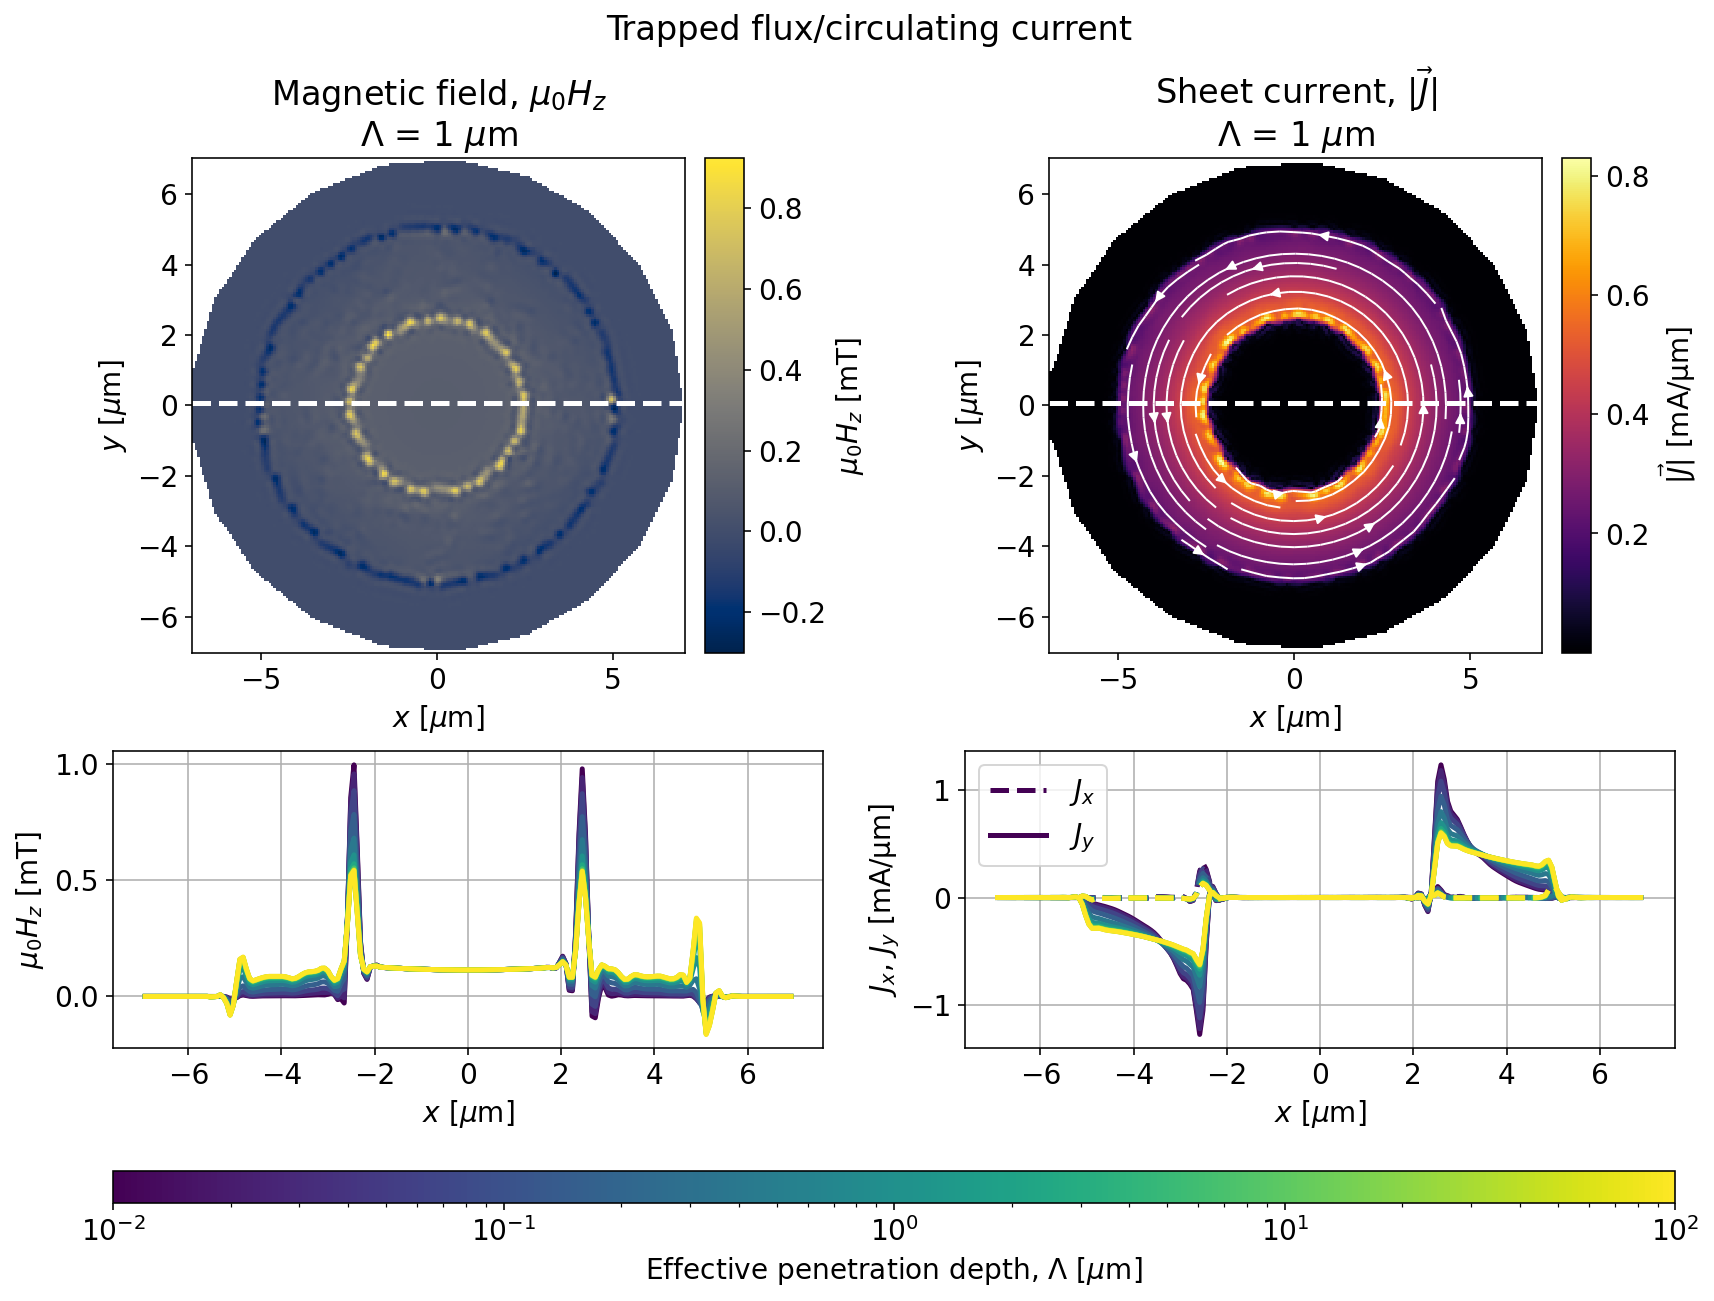

In [115]:
fig, axes = plot_solutions(solutions, Lambdas)
fig.suptitle("Trapped flux/circulating current")
# fig.subplots_adjust(top=0.925, bottom=0.21)

In [116]:
applied_field = sc.sources.ConstantField(0.2)

solutions = []

for Lambda in Lambdas:
    ring.layers["base"].Lambda = Lambda
    
    solutions.append(
        sc.solve(
            device=ring,
            applied_field=applied_field,
            field_units=field_units,
        )[-1]
    )

INFO:superscreen.brandt:Calculating base response to applied field.
INFO:superscreen.brandt:Calculating base response to applied field.
INFO:superscreen.brandt:Calculating base response to applied field.
INFO:superscreen.brandt:Calculating base response to applied field.
INFO:superscreen.brandt:Calculating base response to applied field.
INFO:superscreen.brandt:Calculating base response to applied field.
INFO:superscreen.brandt:Calculating base response to applied field.
INFO:superscreen.brandt:Calculating base response to applied field.
INFO:superscreen.brandt:Calculating base response to applied field.
INFO:superscreen.brandt:Calculating base response to applied field.
INFO:superscreen.brandt:Calculating base response to applied field.


Text(0.5, 0.98, 'Screening (uniform field)')

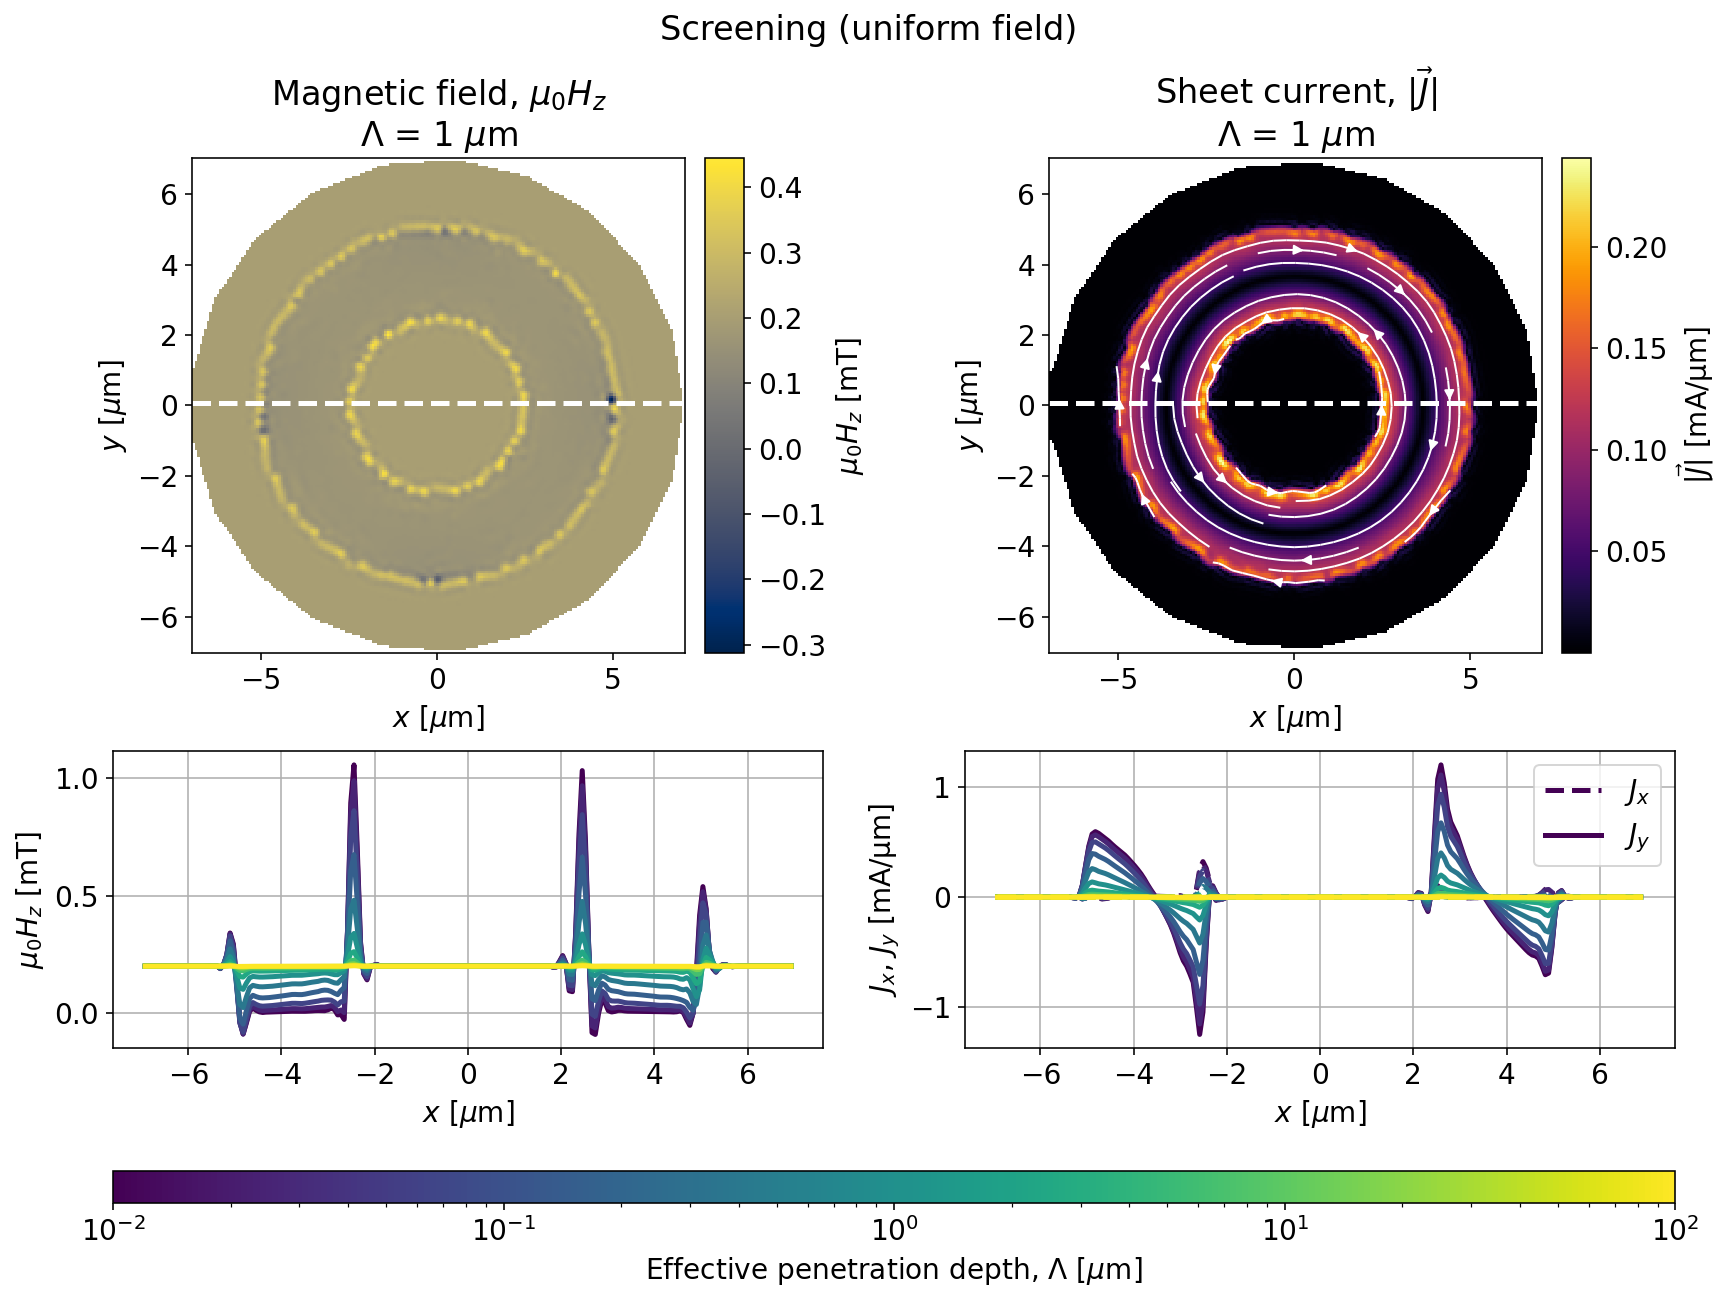

In [117]:
fig, axes = plot_solutions(solutions, Lambdas)
fig.suptitle("Screening (uniform field)")
# fig.subplots_adjust(top=0.925, bottom=0.21)